<a href="https://colab.research.google.com/github/GuillermoChin/AyudaPerla/blob/main/KalmanPerla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RMSE [x1, x2, v1, v2] = [0.00134227 0.00120958 0.04597763 0.05747732]


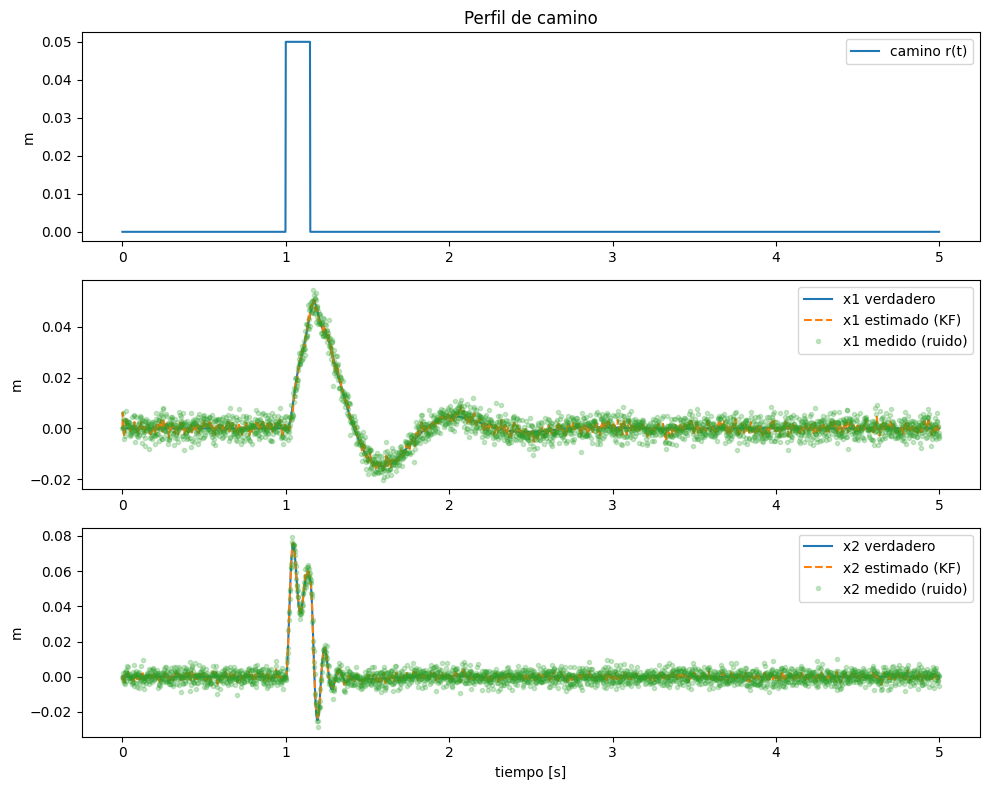

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# -------- parámetros físicos (quarter-car) ----------
m1, m2 = 250.0, 40.0      # kg (carrocería 1/4, masa no suspendida)
k1, c1 = 15000.0, 1500.0  # N/m, N·s/m (suspensión)
k2 = 200000.0             # N/m (neumático; damping ignorado)
Ts = 0.002                # s (2 ms)

# -------- matrices continuas ----------
A = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [-(k1/m1),   (k1/m1),   -(c1/m1),   (c1/m1)],
    [ (k1/m2), -(k1+k2)/m2,  (c1/m2),  -(c1/m2)]
], dtype=float)

B = np.array([[0.0],
              [0.0],
              [0.0],
              [k2/m2]], dtype=float)  # entrada u = r(t)

C = np.array([[1,0,0,0],
              [0,1,0,0]], dtype=float)

# -------- discretización simple (Euler hacia adelante) ----------
Ad = np.eye(4) + Ts*A
Bd = Ts*B
Cd = C

# -------- simulación ----------
T_end = 5.0
N = int(T_end/Ts)
t = np.arange(N)*Ts

# perfil de camino: escalón de 5 cm entre t0 y t1
r = np.zeros(N)
t0, t1 = 1.0, 1.15
r[(t>=t0) & (t<t1)] = 0.05  # 5 cm

# ruido de medida (posiciones)
sigma_meas = 0.003  # 3 mm
R = np.diag([sigma_meas**2, sigma_meas**2])

# ruido de proceso (modelo ligeramente incierto)
q_pos, q_vel = 1e-6, 1e-3   # tuneable
Q = np.diag([q_pos, q_pos, q_vel, q_vel])

# estados "verdaderos"
x_true = np.zeros((4, N))
z_meas = np.zeros((2, N))

# inicial
x = np.zeros(4)

for k in range(1, N):
    u = np.array([r[k-1]])
    x = Ad @ x + Bd @ u
    x_true[:,k] = x
    # medición ruidosa
    z_meas[:,k] = Cd @ x + np.random.normal(0, sigma_meas, size=2)

# --------- Filtro de Kalman ----------
xhat = np.zeros((4, N))
P = np.eye(4)*1.0  # covarianza inicial

for k in range(1, N):
    # predicción
    u = np.array([r[k-1]])
    xpred = Ad @ xhat[:,k-1] + Bd @ u
    Ppred = Ad @ P @ Ad.T + Q

    # actualización
    y = z_meas[:,k] - (Cd @ xpred)                # innovación
    S = Cd @ Ppred @ Cd.T + R
    K = Ppred @ Cd.T @ np.linalg.inv(S)
    xhat[:,k] = xpred + K @ y
    P = (np.eye(4) - K @ Cd) @ Ppred

# --------- métricas ----------
rmse = np.sqrt(np.mean((x_true - xhat)**2, axis=1))
print("RMSE [x1, x2, v1, v2] =", rmse)

# --------- gráficas ----------
plt.figure(figsize=(10,8))

plt.subplot(3,1,1)
plt.plot(t, r, label='camino r(t)')
plt.ylabel('m')
plt.title('Perfil de camino')
plt.legend()

plt.subplot(3,1,2)
plt.plot(t, x_true[0,:], label='x1 verdadero')
plt.plot(t, xhat[0,:],  '--', label='x1 estimado (KF)')
plt.plot(t, z_meas[0,:], '.', alpha=0.25, label='x1 medido (ruido)')
plt.ylabel('m')
plt.legend()

plt.subplot(3,1,3)
plt.plot(t, x_true[1,:], label='x2 verdadero')
plt.plot(t, xhat[1,:],  '--', label='x2 estimado (KF)')
plt.plot(t, z_meas[1,:], '.', alpha=0.25, label='x2 medido (ruido)')
plt.xlabel('tiempo [s]')
plt.ylabel('m')
plt.legend()

plt.tight_layout()
plt.show()


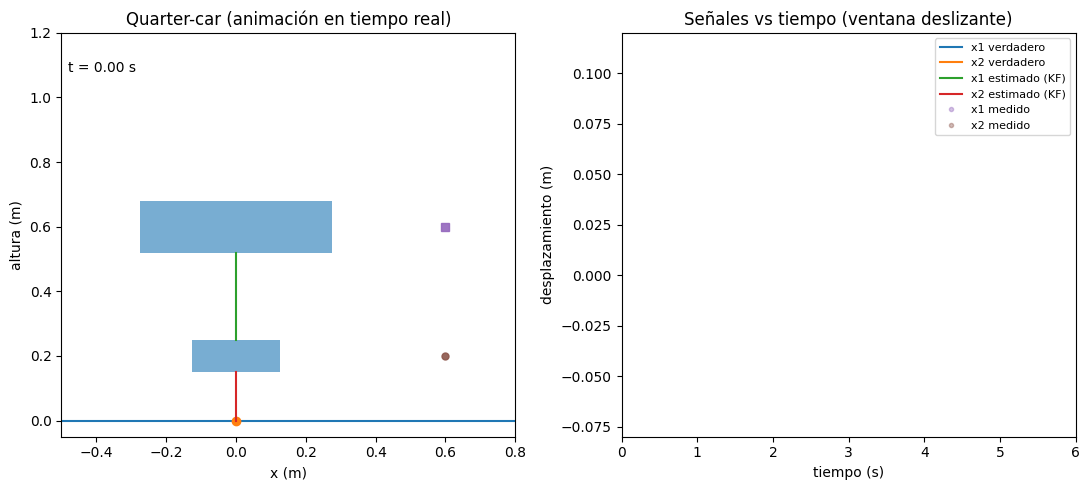

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Quarter-car con Filtro de Kalman y animación "en tiempo real"
- Sistema 2 masas, 2 resortes (suspensión + neumático)
- Entrada r(t) = perfil de camino (bache)
- Medición con ruido: z = [x1, x2] + v
- KF: estima [x1, x2, v1, v2]
- Animación:
    * Panel izquierdo: esquema físico (carrocería, rueda, resortes, bache)
    * Panel derecho: señales vs tiempo (x1/x2 verdadero, estimado y medido) con ventana deslizante
"""
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

# -------- parámetros físicos (quarter-car) ----------
m1, m2 = 250.0, 40.0      # kg (carrocería 1/4, masa no suspendida)
k1, c1 = 15000.0, 1500.0  # N/m, N·s/m (suspensión)
k2 = 200000.0             # N/m (neumático; damping ignorado)

# -------- configuración temporal ----------
Ts = 0.02     # s (50 Hz "tiempo real")
T_end = 12.0  # s
N = int(T_end/Ts)
t = np.arange(N)*Ts

# -------- matrices continuas ----------
A = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [-(k1/m1),   (k1/m1),   -(c1/m1),   (c1/m1)],
    [ (k1/m2), -(k1+k2)/m2,  (c1/m2),  -(c1/m2)]
], dtype=float)

B = np.array([[0.0],
              [0.0],
              [0.0],
              [k2/m2]], dtype=float)  # entrada u = r(t)

C = np.array([[1,0,0,0],
              [0,1,0,0]], dtype=float)

# -------- discretización (Euler hacia adelante) ----------
Ad = np.eye(4) + Ts*A
Bd = Ts*B
Cd = C

# -------- perfil de camino r(t) ----------
r = np.zeros(N)
# tren de baches suaves
for center in [2.0, 5.0, 8.0, 10.0]:
    width = 0.3  # s
    r += 0.05 * np.exp(-0.5*((t-center)/width)**2)  # hasta 5 cm

# -------- ruido --------
sigma_meas = 0.003  # 3 mm
R = np.diag([sigma_meas**2, sigma_meas**2])

q_pos, q_vel = 1e-6, 5e-4
Q = np.diag([q_pos, q_pos, q_vel, q_vel])

# -------- simulación y KF en línea ----------
x_true = np.zeros(4)          # estado real
xhat   = np.zeros(4)          # estimación KF
P      = np.eye(4)*1.0        # covarianza inicial

# buffers para la gráfica temporal (ventana deslizante)
window_s = 6.0
W = int(window_s/Ts)
buffer_t  = []
buffer_x1 = []
buffer_x2 = []
buffer_x1hat = []
buffer_x2hat = []
buffer_x1meas = []
buffer_x2meas = []

# -------- figura y ejes ----------
fig = plt.figure(figsize=(11,5))
ax_anim = fig.add_subplot(1,2,1)
ax_plot = fig.add_subplot(1,2,2)

ax_anim.set_xlim(-0.5, 0.8)
ax_anim.set_ylim(-0.05, 1.2)
ax_anim.set_xlabel('x (m)')
ax_anim.set_ylabel('altura (m)')
ax_anim.set_title('Quarter-car (animación en tiempo real)')

# Geometría para la animación
scale = 1.0
base_m2 = 0.20   # altura base rueda
base_m1 = 0.60   # altura base carrocería
wheel_width = 0.25
wheel_height = 0.1
body_width = 0.55
body_height = 0.16

# elementos gráficos
ground_line, = ax_anim.plot([-0.5, 0.8], [0, 0])
bump_point, = ax_anim.plot([0.0], [r[0]], marker='o')

wheel = plt.Rectangle((-wheel_width/2, base_m2 - wheel_height/2),
                      wheel_width, wheel_height, fill=True, alpha=0.6)
body  = plt.Rectangle((-body_width/2, base_m1 - body_height/2),
                      body_width, body_height, fill=True, alpha=0.6)
ax_anim.add_patch(wheel)
ax_anim.add_patch(body)

spring_susp, = ax_anim.plot([0,0], [base_m2+wheel_height/2, base_m1-body_height/2])
spring_tire, = ax_anim.plot([0,0], [r[0], base_m2 - wheel_height/2])

est_body_point, = ax_anim.plot([0.6], [base_m1], marker='s', markersize=6, alpha=0.9)
est_wheel_point, = ax_anim.plot([0.6], [base_m2], marker='o', markersize=5, alpha=0.9)

time_text = ax_anim.text(-0.48, 1.08, f"t = {0.0:.2f} s")

# eje de señales
ax_plot.set_title('Señales vs tiempo (ventana deslizante)')
ax_plot.set_xlabel('tiempo (s)')
ax_plot.set_ylabel('desplazamiento (m)')
line_x1_true,  = ax_plot.plot([], [], label='x1 verdadero')
line_x2_true,  = ax_plot.plot([], [], label='x2 verdadero')
line_x1_hat,   = ax_plot.plot([], [], label='x1 estimado (KF)')
line_x2_hat,   = ax_plot.plot([], [], label='x2 estimado (KF)')
line_x1_meas,  = ax_plot.plot([], [], '.', alpha=0.4, label='x1 medido')
line_x2_meas,  = ax_plot.plot([], [], '.', alpha=0.4, label='x2 medido')
ax_plot.legend(loc='upper right', fontsize=8)

def init():
    # colocar elementos iniciales
    bump_point.set_data([0.0], [r[0]])
    wheel.set_xy((-wheel_width/2, base_m2 - wheel_height/2))
    body.set_xy((-body_width/2, base_m1 - body_height/2))
    spring_susp.set_data([0,0], [base_m2+wheel_height/2, base_m1-body_height/2])
    spring_tire.set_data([0,0], [r[0], base_m2 - wheel_height/2])
    est_body_point.set_data([0.6], [base_m1])
    est_wheel_point.set_data([0.6], [base_m2])
    time_text.set_text(f"t = {0.0:.2f} s")

    # limpiar curvas
    line_x1_true.set_data([], [])
    line_x2_true.set_data([], [])
    line_x1_hat.set_data([], [])
    line_x2_hat.set_data([], [])
    line_x1_meas.set_data([], [])
    line_x2_meas.set_data([], [])
    ax_plot.set_xlim(0, window_s)
    ax_plot.set_ylim(-0.08, 0.12)
    return (ground_line, bump_point, wheel, body, spring_susp, spring_tire,
            est_body_point, est_wheel_point, time_text,
            line_x1_true, line_x2_true, line_x1_hat, line_x2_hat, line_x1_meas, line_x2_meas)

def animate(k):
    global x_true, xhat, P

    # ---- PLANTA (predicción "real") ----
    u = np.array([r[k-1]]) if k > 0 else np.array([r[0]])
    x_true = Ad @ x_true + Bd @ u

    # ---- MEDICIÓN ----
    z = C @ x_true + np.random.normal(0, [sigma_meas, sigma_meas])

    # ---- KALMAN ----
    # predicción
    xpred = Ad @ xhat + Bd @ u
    Ppred = Ad @ P @ Ad.T + Q
    # actualización
    y = z - (C @ xpred)
    S = C @ Ppred @ C.T + R
    K = Ppred @ C.T @ np.linalg.inv(S)
    xhat[:] = xpred + K @ y
    P = (np.eye(4) - K @ C) @ Ppred

    # ---- actualizar animación física ----
    # posiciones "visuales"
    x2_disp = base_m2 + x_true[1]*scale + r[k]
    x1_disp = base_m1 + x_true[0]*scale
    x2_hat_disp = base_m2 + xhat[1]*scale + r[k]
    x1_hat_disp = base_m1 + xhat[0]*scale

    bump_point.set_data([0.0], [r[k]])
    wheel.set_xy((-wheel_width/2, x2_disp - wheel_height/2))
    body.set_xy((-body_width/2, x1_disp - body_height/2))
    spring_susp.set_data([0,0], [x2_disp + wheel_height/2, x1_disp - body_height/2])
    spring_tire.set_data([0,0], [r[k], x2_disp - wheel_height/2])
    est_body_point.set_data([0.6], [x1_hat_disp])
    est_wheel_point.set_data([0.6], [x2_hat_disp])

    time_text.set_text(f"t = {k*Ts:.2f} s")

    # ---- actualizar buffers del plot temporal ----
    buffer_t.append(t[k])
    buffer_x1.append(x_true[0])
    buffer_x2.append(x_true[1])
    buffer_x1hat.append(xhat[0])
    buffer_x2hat.append(xhat[1])
    buffer_x1meas.append(z[0])
    buffer_x2meas.append(z[1])

    # aplicar ventana deslizante
    if len(buffer_t) > W:
        buffer_t.pop(0); buffer_x1.pop(0); buffer_x2.pop(0)
        buffer_x1hat.pop(0); buffer_x2hat.pop(0)
        buffer_x1meas.pop(0); buffer_x2meas.pop(0)

    t0 = max(0.0, buffer_t[-1] - window_s)
    ax_plot.set_xlim(t0, t0 + window_s)

    # actualizar datos
    line_x1_true.set_data(buffer_t, buffer_x1)
    line_x2_true.set_data(buffer_t, buffer_x2)
    line_x1_hat.set_data(buffer_t, buffer_x1hat)
    line_x2_hat.set_data(buffer_t, buffer_x2hat)
    line_x1_meas.set_data(buffer_t, buffer_x1meas)
    line_x2_meas.set_data(buffer_t, buffer_x2meas)

    return (ground_line, bump_point, wheel, body, spring_susp, spring_tire,
            est_body_point, est_wheel_point, time_text,
            line_x1_true, line_x2_true, line_x1_hat, line_x2_hat, line_x1_meas, line_x2_meas)

if __name__ == "__main__":
    ani = animation.FuncAnimation(
        fig, animate, init_func=init,
        frames=N, interval=Ts*1000, blit=True)
    plt.tight_layout()
    plt.show()
